# Gradient Descent from Scratch

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_moons

### Artificial Data

We use the scikit library for data generation. This data is pleasant to work with, because the values are close to zero.

In [2]:
X, yt = make_moons(n_samples=500, noise=0.2)

In [3]:
X.shape, yt.shape

((500, 2), (500,))

<Axes: xlabel='x1', ylabel='x2'>

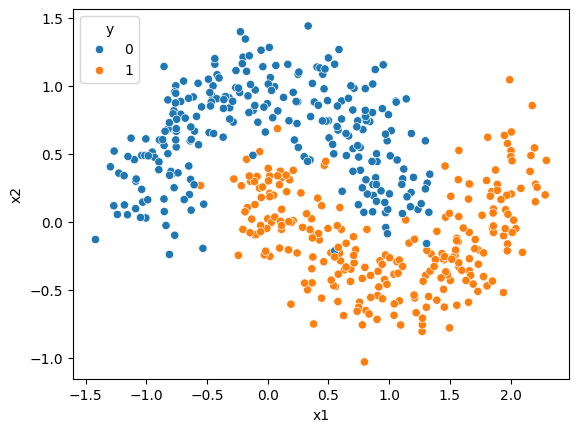

In [4]:
# make a DataFrame for plotting
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = yt
sns.scatterplot(data=df, x="x1", y="x2", hue="y")

### Function Definitions

In [5]:
def sigmoid(X, w):
    return 1 / (1 + np.exp(- np.dot(X, w)))

In [6]:
def logloss(yt, yhat) -> float:
    return np.sum(-yt * np.log(yhat) - (1-yt) * np.log(1 - yhat))

In [7]:
def sigmoid_prime(X, w):
    return sigmoid(X, w) * (1 - sigmoid(X, w))

In [8]:
def logloss_prime(yt, X, w):
    sig = sigmoid(X, w)
    return - (yt / sig) + ((1 - yt) / (1 - sig))

In [9]:
def mlp(X, wh, wo):
    """a two-layer neural network with hidden weights and output weights"""
    yhidden = sigmoid(X, wh)
    yhidden_with_bias = np.hstack([yhidden, np.ones((yhidden.shape[0], 1))])
    yhat = sigmoid(yhidden_with_bias, wo)
    return yhidden, yhat   # return outputs of both layers, because they are needed for backpropagation

### Experiment 1: Gradient Descent on LogReg model

**Expectation:** robust but not expecting great results. LogReg is placing a straight line as a decision boundary. So it fails to model the tips of the crescents by default.

<Axes: >

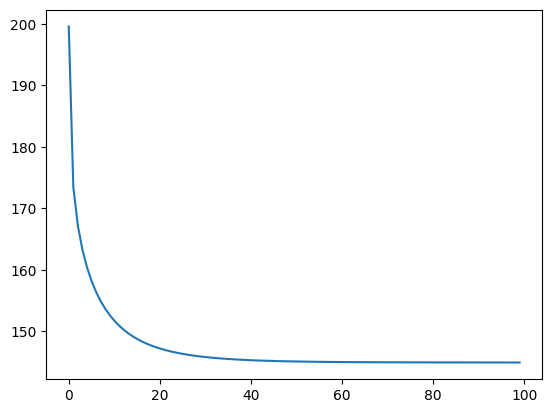

In [10]:
Xb = np.hstack([X, np.ones((X.shape[0], 1))])  # add bias column
w = np.random.normal(size=(Xb.shape[1]))       # create random parameters
learning_rate = 0.01
epochs = 100

history = []
for i in range(epochs):
    gradient = np.dot(logloss_prime(yt, Xb, w) * sigmoid_prime(Xb, w), Xb)   # 50 dot 50, 3  -> 3
    w = w - gradient * learning_rate
    yhat = sigmoid(Xb, w)
    history.append(logloss(yt, yhat))

sns.lineplot(history)

In [11]:
accuracy = np.mean(np.round(yhat) == yt) 
accuracy

np.float64(0.848)

<Axes: xlabel='x1', ylabel='x2'>

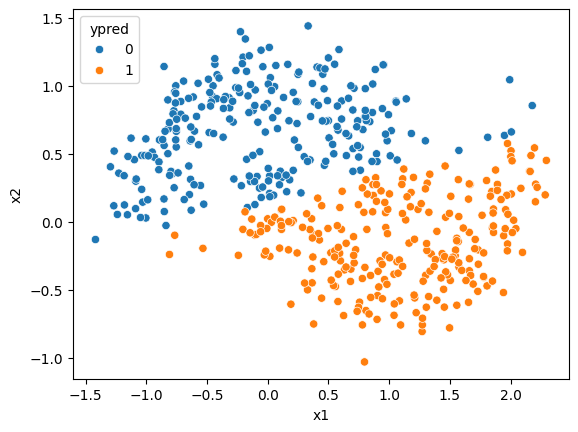

In [12]:
df["ypred"] = np.round(yhat).astype(int)
df["ytrue"] = yt
sns.scatterplot(data=df, x="x1", y="x2", hue="ypred")

### Experiment 2: Feature Engineering

We are adding polynomial terms so that the model can fit more parameter. The classical approach.

In [13]:
bias = np.ones((X.shape[0], 1))
x1square = X[:, 0] ** 2
x2square = X[:, 1] ** 2
x1third = X[:, 0] ** 3
x2third = X[:, 1] ** 3
Xb = np.hstack([X,
                x1square.reshape(X.shape[0], 1), 
                x2square.reshape(X.shape[0], 1),
                x1third.reshape(X.shape[0], 1),
                x2third.reshape(X.shape[0], 1),
                bias
               ])

# normalize each column by the mean
Xb = Xb / Xb.mean(axis=0)

Xb.shape

(500, 7)

<Axes: >

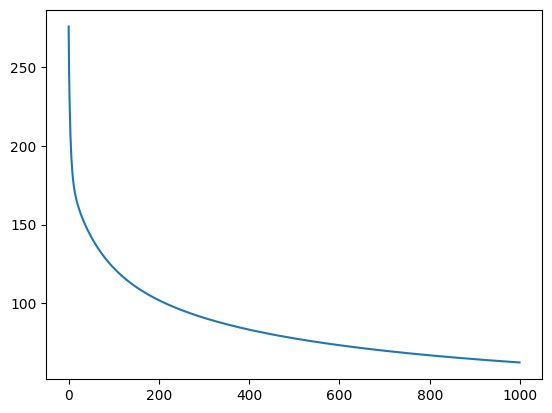

In [14]:
w = np.random.normal(size=(Xb.shape[1]))       # create random parameters
learning_rate = 0.001
epochs = 1000

history = []
for i in range(epochs):
    gradient = np.dot(logloss_prime(yt, Xb, w) * sigmoid_prime(Xb, w), Xb)   # 50 dot 50, 3  -> 3
    w = w - gradient * learning_rate
    yhat = sigmoid(Xb, w)
    history.append(logloss(yt, yhat))

sns.lineplot(history)

In [15]:
accuracy = np.mean(np.round(yhat) == yt) 
accuracy

np.float64(0.968)

<Axes: xlabel='x1', ylabel='x2'>

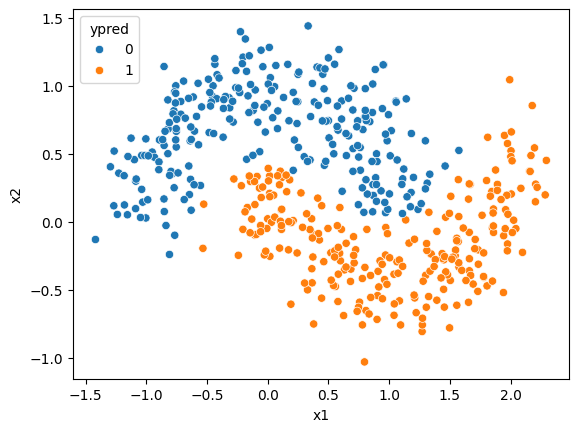

In [16]:
df["ypred"] = np.round(yhat).astype(int)
df["ytrue"] = yt
sns.scatterplot(data=df, x="x1", y="x2", hue="ypred")

#### Conclusion

Works a lot better but feature engineeering is more work, too.

### Experiment 3: Two-Layer Neural Network

We add an extra ANN layer (MLP, Multi-Layer-Perceptron). The Gradient Descent works the same, only we have to modify both sets of weights.
For the weights of the hidden layer we have to use backpropagation (a longer chain rule).

<Axes: >

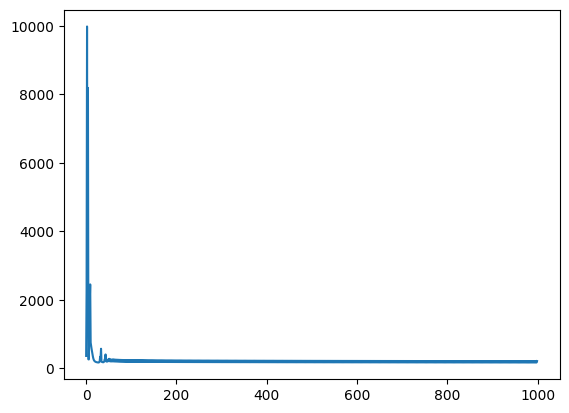

In [61]:
# run gradient descent. Same code but more columns
Xb = np.hstack([X, np.ones((X.shape[0], 1))])  # add bias column -> 500, 3
wh = np.random.normal(loc=1.0, scale=0.5, size=(Xb.shape[1], 2))       # 3 features, 2 hidden neurons
wo = np.random.normal(loc=1.0, scale=0.5, size=(3,))       # 2 hidden neurons + 1 bias, 1 output neuron
learning_rate = 0.07
learning_rate_hidden = 0.1
epochs = 1000

history = []
for i in range(epochs):
    hidden_out, yhat = mlp(Xb, wh, wo)
    hidden_out_bias = np.hstack([hidden_out, np.ones((hidden_out.shape[0], 1))])

    # modify weights of output layer, same as experiment 1
    gradient_out = np.dot(logloss_prime(yt, hidden_out_bias, wo) * sigmoid_prime(hidden_out_bias, wo), hidden_out_bias)   # 50 dot 50, 3  -> 3
    wo = wo - gradient_out * learning_rate

    # backpropagate to hidden layer
    gradient_hidden = np.dot(
        (
            (
            logloss_prime(yt, hidden_out_bias, wo) *  # shape: 500,
            sigmoid_prime(hidden_out_bias, wo) *      # shape: 500,
            hidden_out.T                              # shape: 500, 2
            ).T                                         # -> 500, 2
            * 
            sigmoid_prime(Xb, wh)                      # shape: 500, 2
        ).T,
        Xb).T  # CHECK: might be a bug, but it works sometimes and I got lost in the many transposes
    assert gradient_hidden.shape == (3, 2)
    wh = wh + gradient_hidden * learning_rate_hidden
    #      ^^^ still some small bug here, needs further diagnosis
    
    history.append(logloss(yt, yhat))

sns.lineplot(history)

In [62]:
accuracy = np.mean(np.round(yhat) == yt) 
accuracy

np.float64(0.874)

<Axes: xlabel='x1', ylabel='x2'>

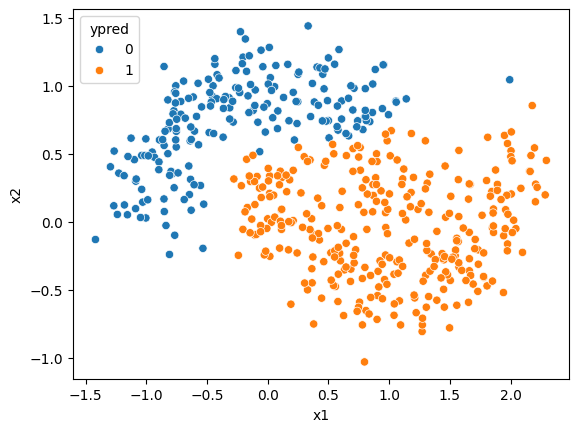

In [63]:
df["ypred"] = np.round(yhat).astype(int)
df["ytrue"] = yt
sns.scatterplot(data=df, x="x1", y="x2", hue="ypred")